# Point set registration

Let's focus on an interesting transformation problem, where we are given two point patterns (sets of points) 
$\{x_i\}$ and $\{y_i\}$ with $i = 1,2, \ldots n$ given in a $m$-dimensional space, and we want to find the similarity transformation parameters (rotation, translation and scaling) that give the least mean squared error $\epsilon^{2}(R,t,c)$ between these points patterns.
$$\epsilon^{2}(R,t,c) = \frac{1}{n} \displaystyle \sum_{i=1}^{n}||y_{i}-(cRx_{i}+t)||^2 $$.

Let's start by taking a set of points $\{y_i\}$ of $\mathbb{R}^{2}$ with $i = 1,2, \ldots n$ which together take the shape of a heart in the cartesian plane, and cosider a set of points $\{x_{i}\}$ of $\mathbb{R}^{2}$ with $i = 1,2, \ldots n$ wich are a rotation, translation and scaling of all the points $\{y_{i}\}$.


In [15]:
θ = π/4;  φ = π/2;

fx(t) = 2*(1+cos(φ))*(sin(t))^3
fy(t) = 2*cos(θ)*(sin(t))^2*sin(φ)+ sin(θ)*cos(t)*(cos(2t)-2*cos(φ)*(sin(t))^2-3)

N = 30;
ts = LinRange(0,2π,N);
tu = LinRange(-3,-3,N);

y_1 = fx.(ts);
y_2 = fy.(ts);
pointsy = [y_1 y_2];

x_1 = fx.(ts)*0.2 + tu;
x_2 = fy.(ts)*0.2 + tu;
pointsx = [x_1 x_2];

α = 3π/4
G = [cos(α) sin(α) ; -sin(α) cos(α)];
for i = 1:N
    pointsx[i,:] = G*pointsx[i, :]
end

N = size(pointsy,1);

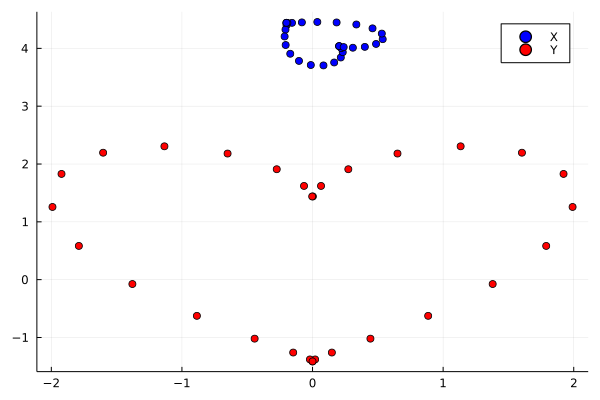

In [16]:
using Plots
plot(pointsx[:,1], pointsx[:,2], seriestype = :scatter, color=:blue, label= "X")
plot!(pointsy[:,1], pointsy[:,2], seriestype = :scatter, color=:red, label= "Y")

For our purpose we must calculate the vectors $ \displaystyle \mu_{x} = \frac{1}{n}  \sum_{i=1}^{n}x_{i} $ and  $ \displaystyle \mu_{y} = \frac{1}{n} \sum_{i=1}^{n}y_{i} $, known as the mean vectors of $ \displaystyle \{x_{i}\}$ and $\displaystyle \{y_{i}\}$ respectively.


In [17]:
function niu_v(points)
    niu = fill(0,2)
    for i = 1:N
    niu = points[i,:] + niu
    end
    niu = (1/N)*niu
end

niu_x = niu_v(pointsx);
niu_y = niu_v(pointsy);

Using the above vectors, we must calculate the following constants $ \displaystyle  \sigma_{x}^{2} = \frac{1}{n} \sum_{i=1}^{n}||x_{i}- \mu_{x}||^{2}$ and  $ \displaystyle  \sigma_{y}^{2} = \frac{1}{n} \sum_{i=1}^{n}||y_{i}- \mu_{y}||^{2}$, wich are the variances around the mean vectors of $ \displaystyle \{x_{i}\}$ and $\displaystyle \{y_{i}\}$ respectively.

In [18]:
using LinearAlgebra
function sigma_v(points, niu)
    sigma = 0
    for i = 1:N
        sigma = (norm(points[i,:]-niu))^2 + sigma 
    end
    sigma = (1/N)*sigma
end

sigma_sq_x = sigma_v(pointsx, niu_x);
sigma_sq_y = sigma_v(pointsy, niu_y);

And finally we must calculate the covariance matrix of $\{x_{i}\}$ and $\{y_{i}\}$, wich is defined as $\displaystyle \Sigma_{xy} = \frac{1}{n} \sum_{i=1}^{n} (y_{i}- \mu_{y})(x_{i}- \mu_{x})^{T}$

In [19]:
M = size(pointsy,2)
Sigma_xy = fill(0, M, M)
for i = 1:N
    Sigma_xy = (pointsy[i,:]-niu_y)*transpose((pointsx[i,:]-niu_x)) + Sigma_xy
end

Sigma_xy = (1/N)*Sigma_xy;

Now, let a singular value descomposition (SVD) of the matrix $\Sigma_{xy}$ be $UDV^{T}$, where $D = diag(d_{i})$ with $d_{1} \geq d_{2} \geq \ldots \geq d_{m} \geq 0$.


In [20]:
#Singular value descomposition
U, D, V = svd(Sigma_xy)

SVD{Float64, Float64, Matrix{Float64}}
U factor:
2×2 Matrix{Float64}:
 -4.44089e-16  1.0
  1.0          3.22943e-16
singular values:
2-element Vector{Float64}:
 0.3914999999999999
 0.24166666666666659
Vt factor:
2×2 Matrix{Float64}:
  0.707107  -0.707107
 -0.707107  -0.707107

In [21]:
U*diagm(D)*transpose(V)

2×2 Matrix{Float64}:
 -0.170884  -0.170884
  0.276832  -0.276832

The optimum transformation parameters are determined uniquely as follows:
\begin{align*}
 & R = USV^{T} \\
 & t = \mu_{y} - cR \mu_{x} \\
 & c = \frac{1}{\sigma_{x}^{2}} tr(DS)
\end{align*}
where $R$ is the rotation matrix, $t$ is the vector of translation, $c$ is the constant of scaling and $S$ is a matrix defined as follows:

When $rank(\Sigma_{xy}) > m-1$, then $S$ must be chosen as 

$$S = \left\{ \begin{array}{ll}
             I &   if  & det(\Sigma_{xy}) \geq 0 \\
             diag(1,1, \ldots, -1) &  if & det(\Sigma_{xy}) < 0 \\
             \end{array}
   \right.$$
   
  
and if $rank(\Sigma_{xy}) = m-1$, $S$ must be chosen as 

$$S= \left\{ \begin{array}{ll}
             I &   if  & det(U)det(V) = 1 \\
             diag(1,1, \ldots, -1) &  if & det(U)det(V) = -1 \\
             \end{array}
   \right.$$

In [40]:
function matrix_S()
    if det(Sigma_xy) ≥ 0
        I
    else
        [1 0; 0 -1]
    end
end

function matrix_S2()
    if det(U)*det(V) == 1
        [1 0; 0 1]
    else
        [1 0; 0 -1]
    end
end

if rank(Sigma_xy) > length(D)-1
    
    S = matrix_S();
    R = U*S*transpose(V);
    c = (1/sigma_sq_x)*tr(diagm(D)*S);
    t = niu_y - c*R*niu_x;
    
else
    
    S = matrix_S2();
    R = U*S*transpose(V);
    c = (1/sigma_sq_x)*tr(diagm(D)*S);
    t = niu_y - c*R*niu_x;

end

2-element Vector{Float64}:
 14.999999999999996
 14.999999999999993

In [25]:
println(R)
println(c)
println(t)

[-0.7071067811865475 -0.7071067811865477; 0.7071067811865478 -0.7071067811865474]
4.999999999999998
[14.999999999999996, 14.999999999999993]


Now, the minimum value $\epsilon^{2}$ of the mean squared error 
$$ \displaystyle \epsilon^{2}(R,t,c) = \frac{1}{n} \displaystyle \sum_{i=1}^{n}||y_{i}-(cRx_{i}+t)||^2$$
of these two point patterns with respect to the similarity transformation parameters ($R$: rotation, $t$: translation, and $c$: scaling) is given by 
$$\epsilon^{2} = \sigma_{y}^{2} - \frac{tr(DS)^{2}}{\sigma_{x}^{2}} $$
let's check it out.

In [32]:
ε_squared = sigma_sq_y - (tr(diagm(D)*S))^2/sigma_sq_x

1.3322676295501878e-15

Before computing the second error, we must apply the transformation to the set of points $\{x_{i}\}$, giving as a result the point set $\{ \hat y_{i} \}$.

In [33]:
yhat = fill(0.,N,M)

for i = 1:N
    yhat[i, :] = c*R*pointsx[i,:]+t
end 

ε_sq = 0
for i = 1:N
    ε_sq += (norm(pointsy[i,:]-model[i, :]))^2
end
ε_squared = (1/N)*ε_sq

5.403960467613393e-30

We plot the solution:

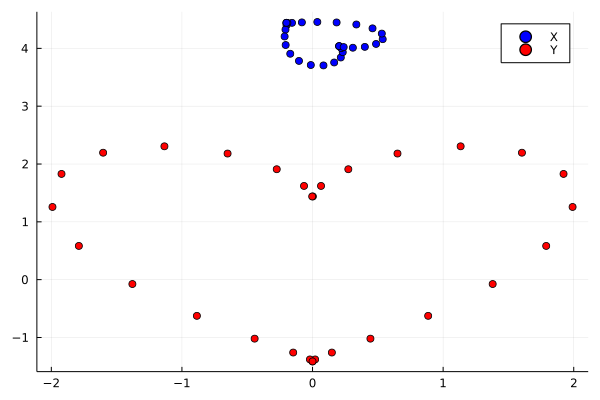

In [34]:
using Plots
plot(pointsx[:,1], pointsx[:,2], seriestype = :scatter, color=:blue, label= "X")
plot!(pointsy[:,1], pointsy[:,2], seriestype = :scatter, color=:red, label= "Y")

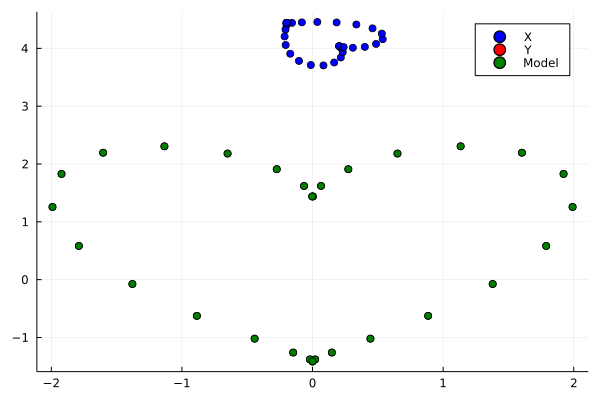

In [36]:
using Plots
plot(pointsx[:,1], pointsx[:,2], seriestype = :scatter, color=:blue, label= "X")
plot!(pointsy[:,1], pointsy[:,2], seriestype = :scatter, color=:red, label= "Y")
plot!(yhat[:,1], yhat[:,2], seriestype = :scatter, color=:green, label= "Model")

We can visualize this transformation in the following gif:

┌ Info: Saved animation to 
│   fn = C:\Users\felip\OneDrive\Documentos\MathML\Taller 1\tmp.gif
└ @ Plots C:\Users\felip\.julia\packages\Plots\zozYv\src\animation.jl:114


Plots.AnimatedGif("C:\\Users\\felip\\OneDrive\\Documentos\\MathML\\Taller 1\\tmp.gif")
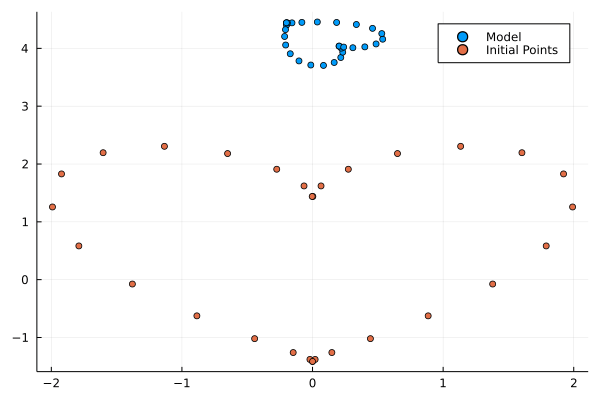

In [41]:
ɣ = acos(R[1,1])
Rot = Array([cos(ɣ) -sin(ɣ) ; sin(ɣ) cos(ɣ)])
if (1+((c-1)/ɣ))ɣ *pointsx*Rot' + ɣ/ɣ *ones(N,M)*diagm(t) == yhat
    ɣ = ɣ
else 
    ɣ = -ɣ
end

@gif for i in range(0, ɣ , 200)
    Q = Array([cos(i) -sin(i) ; sin(i) cos(i)])
    X = (1+((c-1)/ɣ)*i)*pointsx*Q + i/ɣ *ones(N,M)*diagm(t)
    scatter(X[:,1], X[:,2], label = "Model" )
    scatter!(pointsy[:,1], pointsy[:,2], label = "Initial Points")
end 